In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import LearningRateScheduler
from nltk.tokenize import RegexpTokenizer
from pymystem3 import Mystem
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score
%matplotlib inline


DIM = 5


def put_zeros(arr):
    for i in range(len(arr) - 1, -1, -1):
        if arr[i] != 1:
            break
        arr[i] = 0
    return arr


def fill_with_zeros(texts):
    result = [[put_zeros(x[0]), put_zeros(x[1])] for x in texts]
    return result


def concat_arr(texts):
    result = np.array([np.array(x[0] + x[1][:100]) for x in texts])
    return result

def str_to_list(text: str) -> list:
    """ convert text with comma-delimiters to list and
    replace special chars as spaces """
    txt = text.replace("[", "") \
        .replace("]", "") \
        .replace("'", "") \
        .replace("\n", "")
    result = [elem.strip() for elem in txt.split(",")]
    return result


def tokenize(text: str) -> list:
    """ tokenize """
    txt = text.replace(".", " ЕОС ") \
        .replace(";", " ЕОС ") \
        .replace("!", " ЕОС ") \
        .replace("?", " ЕОС ") \
        .replace('\n', "")
    tokenizer = RegexpTokenizer(r'[0-9A-Fa-fА-Яа-я\-\`\,ё]+')
    txt = tokenizer.tokenize(txt)
    return txt


def lemmatize(text: list) -> list:
    """ lemmatize """
    mystem = Mystem()
    text = " ".join(text)
    return [wo for wo in mystem.lemmatize(text) if wo not in [" ", "\n"]]


def pad(arr, padding, max_len):
    """ pad to 400 words"""
    result = arr + ([padding] * (max_len - len(arr)))
    return result


def truncate_or_pad(arr, padding, max_len=400):
    """ truncate or pad array """
    if len(arr) < max_len:
        return pad(arr, padding, max_len)
    return arr[:max_len]


class F1Metrics(Callback):
    """ F1Metrics"""
    def __init__(self, validation_data, **kwargs):
        super(F1Metrics, self).__init__(**kwargs)
        self.validation_data = validation_data
        self.val_f1s = []
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_true = self.validation_data[1]
        val_f1 = f1_score(val_true, val_predict, average='macro')
        self.val_f1s.append(val_f1)
        print(f"F1={val_f1}")
        return


def f1_metric(y_true, y_pred):
    not_y_pred = np.logical_not(y_pred)
    y_int1 = y_true*y_pred
    y_int0 = np.logical_not(y_true)*not_y_pred
    TP = np.sum(y_pred*y_int1)
    FP = np.sum(y_pred)-TP
    FN = np.sum(not_y_pred)-np.sum(not_y_pred*y_int0)
    f1 = np.float(TP*2) / (TP + FN + TP + FP)
    return f1

In [ ]:
with open("vocabulary.pkl", "rb") as f:
    vocab = pickle.load(f)

df = pd.read_csv("recipes_nlp_data.csv")
df.count()

In [ ]:
num_texts = []
texts = df[["text", "ingreds"]].values
y_true = df["cuisine"].values
result = []

for p in range(texts.shape[0]):
    directions_tokenized = tokenize(texts[p][0])
    ingr_tokenized = tokenize(texts[p][1])
    dirs = [vocab.get(w) if vocab.get(w) else 0 for w in directions_tokenized]
    ingredients = [vocab.get(w) if vocab.get(w) else 0 for w in ingr_tokenized]
    result.append(truncate_or_pad(dirs, 0) + truncate_or_pad(ingredients, 0, max_len=100))

max_words = len(vocab)

y_gt = np.zeros(shape=(len(y_true), DIM))
for i in range(len(y_true)):
    y_gt[i][y_true[i]-1] = 1


ndx = list(range(len(y_true)))
np.random.shuffle(ndx)

result = np.array(result)
train_feats, test_feats = result[ndx[:13948]], result[ndx[13948:]]
train_lbl, test_lbl = y_gt[ndx[:13948]], y_gt[ndx[13948:]]
print(train_lbl.shape, test_lbl.shape, max_words)


In [4]:
import csv
from copy import copy, deepcopy
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from pymystem3 import Mystem

my_stopwords = stopwords.words('russian')
MAX_LEN = 400


In [ ]:
####################################################
## train cuisine type classifier using Bidirectional RNN
####################################################
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam

def schedule(ep, lr):
    return lr * 0.95


seed = 111
np.random.seed(seed)
learning_rate = 0.0025 # initial learning rate
batch_size = 128 # Batch size for training
mod = keras.models.Sequential()
mod.add(layers.Embedding(max_words+1, 100, input_length=500))
mod.add(Bidirectional(LSTM(28, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)))
mod.add(Bidirectional(LSTM(28, dropout=0.1, recurrent_dropout=0.1)))
mod.add(Dense(DIM, activation="softmax"))
mod.summary()
np.random.seed(seed)

opt = Adam(learning_rate=learning_rate)
sch = LearningRateScheduler(schedule)
sch2 = callbacks.ModelCheckpoint(filepath="./new_rnn2_with_embed.h5", monitor="acc", save_best_only=True)
metr_cb = F1Metrics((test_feats, test_lbl))
mod.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

hist0 = mod.fit(train_feats, train_lbl, epochs=20, batch_size=batch_size, callbacks=[sch, metr_cb],
               validation_data=(test_feats, test_lbl), shuffle=True)
mod.save("./new_rnn_cuisine.h5")


21/21 [==============================] - 4s 196ms/step - loss: 0.1975 - acc: 0.9714


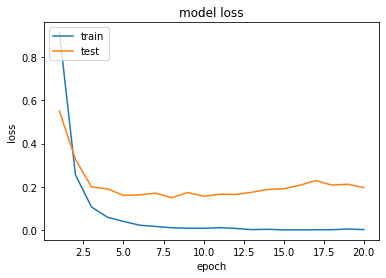

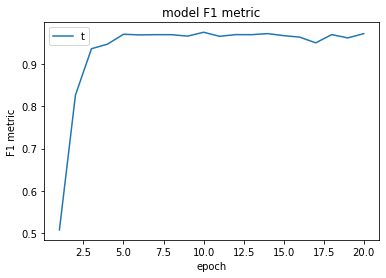

In [14]:
hist = mod.evaluate(x=test_feats, y=test_lbl)

plt.plot(list(range(1, len(hist0.history["loss"])+1)), hist0.history["loss"])
plt.plot(list(range(1, len(hist0.history["loss"])+1)), hist0.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(list(range(1, len(metr_cb.val_f1s)+1)), metr_cb.val_f1s)
plt.title("model F1 metric")
plt.ylabel("F1 metric")
plt.xlabel("epoch")
plt.legend("test", loc="upper left")
plt.show()

del mod

In [ ]:
DIM=7

y_true = df["dish_type"].values
    
y_gt = np.zeros(shape=(len(y_true), DIM))
for i in range(len(y_true)):
    y_gt[i][y_true[i]-1]=1

train_lbl, test_lbl = y_gt[ndx[:13948]], y_gt[ndx[13948:]]
print(len(y_true),train_feats.shape, test_lbl.shape)

In [ ]:
####################################################
## train cuisine type classifier using Bidirectional RNN
####################################################
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam


def schedule(ep, lr):
    return lr * 0.93


seed = 111
np.random.seed(seed)
learning_rate = 0.0025 # initial learning rate
batch_size = 128 # Batch size for training
mod = keras.models.Sequential()
mod.add(layers.Embedding(max_words+1, 100, input_length=500))
mod.add(Bidirectional(LSTM(28, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)))
mod.add(Bidirectional(LSTM(28, dropout=0.3, recurrent_dropout=0.2)))
mod.add(Dense(DIM, activation="softmax"))
mod.summary()
np.random.seed(seed)

opt = Adam(learning_rate=learning_rate)
sch = LearningRateScheduler(schedule)
f1metr = F1Metrics((test_feats, test_lbl))
mod.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

hist1 = mod.fit(train_feats, train_lbl, epochs=21, batch_size=batch_size, callbacks=[sch, f1metr],
               validation_data=(test_feats, test_lbl), shuffle=True)
mod.save("./new_rnn2_dish_type.h5")

In [ ]:
hist = mod.evaluate(x=test_feats, y=test_lbl)

plt.plot(hist1.history["loss"])
plt.plot(hist1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(list(range(1, len(f1metr.val_f1s)+1)), f1metr.val_f1s)
plt.title("model F1 metric")
plt.ylabel("F1 metric")
plt.xlabel("epoch")
plt.legend("test", loc="upper left")
plt.show()
